# Implement smooth covariates 

In [2]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

rng = np.random.default_rng(42)

# Load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

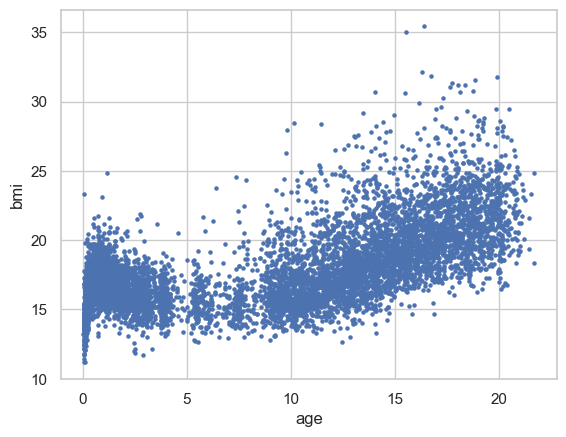

In [3]:
# Plot the data
sns.set_theme(style="whitegrid")
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [5]:
# define a model with intercept 
# set up design matrix 
X = tiger.Obs(name="X_loc", intercept=True)
X.smooth(data=df["age"].to_numpy())
# If we combine fixed covariates and smooth covariates we need to center the the 
# smooth effects first 
X.center()

# fixed coefficents 
# set up beta_fixed hyperparameters 
beta_fixed_loc = tiger.Hyper(0.0, name="beta_fixed_loc")
beta_fixed_scale = tiger.Hyper(100.0, name="beta_fixed_scale")

# set up parameters
beta_fixed_dist = tiger.Dist(tfjd.Normal, loc=beta_fixed_loc, scale=beta_fixed_scale)
beta_fixed = tiger.Param(value=df["bmi"].to_numpy().mean(), distribution=beta_fixed_dist, name="beta_fixed")

# smooth coefficients
# set up hyperparameters for the beta_smooth_scale  
tau_a = tiger.Hyper(0.01, name="tau_a")
tau_b = tiger.Hyper(0.01, name="tau_b")
tau_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau_a, scale=tau_b)
tau = tiger.Param(value=jnp.array([1.0]), distribution=tau_dist, param_space="positive", name="tau")

# smooth coefficients
# ----
# Easy way with the normal
# set up beta_fixed hyperparameters 
# beta_smooth_loc = tiger.Hyper(0.0, name="beta_smooth_loc")

# set up parameters 
# beta_smooth_dist = tiger.Dist(tfjd.Normal, loc=beta_smooth_loc, scale=tau)
# beta_smooth = tiger.Param(value=jnp.repeat(jnp.array([0.0]), X.smooth_dim_cent[0]), distribution=beta_smooth_dist, name="beta_smooth")
# ----

# ----
# set up smooth coefficients with mvn degenerate 
# set up hyperparameters
beta_smooth_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[0]), name="beta_smooth_loc")

# define the penalty matrix 
pen = X.smooth_pen_mat_cent[0]

# set up parameters
beta_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=beta_smooth_loc, scale=tau, pen=pen)
beta_smooth = tiger.Param(value=np.zeros(X.smooth_dim_cent[0]), distribution=beta_smooth_dist, name="beta_smooth")
# ----

# set up the linear predictor
lpred = tiger.Lpred(obs=X, beta_fixed=beta_fixed, beta_smooth=beta_smooth)

# set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

## Test log-prob and setup the graph 

In [6]:
m.log_prob

Array(-23837.824, dtype=float32)

In [7]:
m.log_prior

Array(-31.786938, dtype=float32)

In [8]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [9]:
graph.logprob()

Array(-23837.824, dtype=float32)

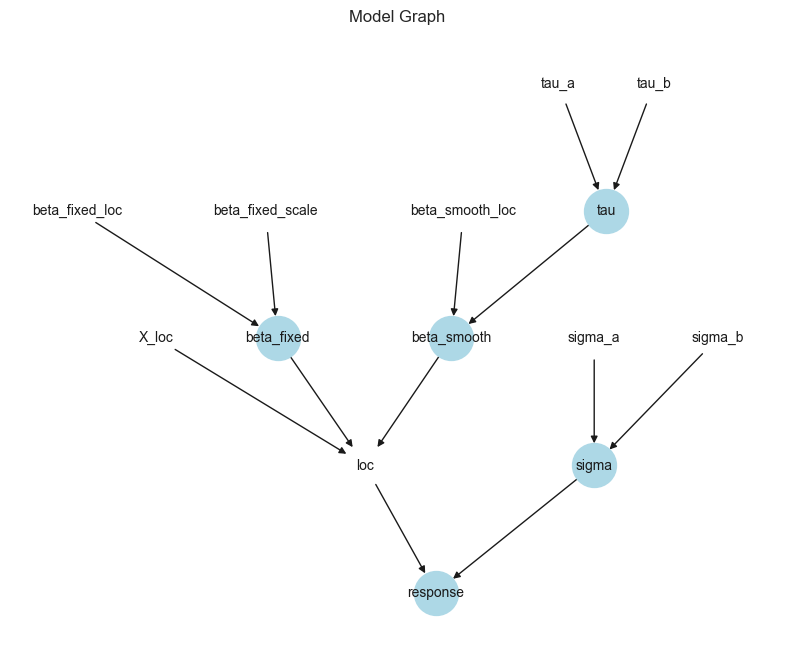

In [10]:
graph.visualize_graph()

## Test functions of Bbvi

In [10]:
import tigerpy.distributions.mvn as mvn
q = bbvi.Bbvi(graph=graph)
key = jax.random.PRNGKey(27)

In [11]:
loc_beta_smooth, lower_tri_beta_smooth = q.init_variational_params["beta_smooth"]["loc"], q.init_variational_params["beta_smooth"]["lower_tri"]
loc_sigma, lower_tri_sigma = q.init_variational_params["sigma"]["loc"], q.init_variational_params["sigma"]["lower_tri"]
loc_tau, lower_tri_tau= q.init_variational_params["tau"]["loc"], q.init_variational_params["tau"]["lower_tri"]

In [12]:
samples_beta_smooth = mvn.mvn_precision_chol_sample(loc=loc_beta_smooth, precision_matrix_chol=lower_tri_beta_smooth, key=key, S=64)
samples_sigma = mvn.mvn_precision_chol_sample(loc=loc_sigma, precision_matrix_chol=lower_tri_sigma, key=key, S=64)
samples_tau = mvn.mvn_precision_chol_sample(loc=loc_tau, precision_matrix_chol=lower_tri_tau, key=key, S=64)

In [13]:
test_samples = {"beta_smooth": samples_beta_smooth,
                "sigma": jnp.exp(samples_sigma),
                "tau": jnp.exp(samples_tau)}

In [14]:
batch_idx = jax.random.choice(key, q.num_obs, (32,), replace=False)

In [15]:
data_new = jax.tree_map(lambda x: x[batch_idx], q.data)

In [16]:
q.graph.update_traversal_order

['tau', 'sigma', 'beta_smooth', 'loc', 'response']

In [17]:
q.mc_logprob(data_new,  test_samples, q.num_obs)

Log-prior: beta_smooth (64,)
Scaled log-lik (64,)
Log-priors (64,)


Array(-296468.44, dtype=float32)

In [18]:
q.lower_bound(q.init_variational_params, 
              data_new,
              num_obs=q.num_obs,
              num_var_samples=64,
              key=key)

Log-prior: beta_smooth (64,)
Scaled log-lik (64,)
Log-priors (64,)


Array(157805.56, dtype=float32)

## Inference with Bbvi

In [11]:
q = bbvi.Bbvi(graph=graph)

In [30]:
import optax
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.,
    peak_value=0.2,
    warmup_steps=100,
    decay_steps=2_000,
    end_value=0.001,
)

In [12]:
q.run_bbvi(step_size=0.001,
           threshold=1e-2,
           key_int=27,
           batch_size=128,
           num_var_samples=64,
           chunk_size=50,
           epochs=2500)

(Array(-13979.922, dtype=float32, weak_type=True),
 {'beta_fixed': {'loc': Array([18.039047], dtype=float32),
   'cov': Array([[0.00060858]], dtype=float32)},
  'tau': {'loc': Array([-0.33155257], dtype=float32),
   'cov': Array([[0.02827917]], dtype=float32)},
  'sigma': {'loc': Array([0.7084373], dtype=float32, weak_type=True),
   'cov': Array([[6.737628e-05]], dtype=float32)},
  'beta_smooth': {'loc': Array([-2.6185398 , -2.626025  , -2.0041518 , -2.2619236 , -2.4003367 ,
          -2.1099794 , -1.6894892 , -1.4016992 , -1.1640717 , -0.6102212 ,
          -0.11400966,  0.45473555,  1.1069152 ,  1.5459895 ,  2.155803  ,
           2.8104978 ,  3.3854773 ,  3.6665118 ,  3.9382844 ], dtype=float32),
   'cov': Array([[ 1.12480270e-02,  4.53613047e-03, -7.77799636e-03,
           -2.20095948e-03,  6.50534523e-04, -3.42867133e-04,
           -1.59051002e-03, -1.14743027e-03, -6.35106198e-06,
           -9.88637214e-04, -1.50797772e-03, -1.06056104e-03,
           -9.45029140e-04, -1.04471

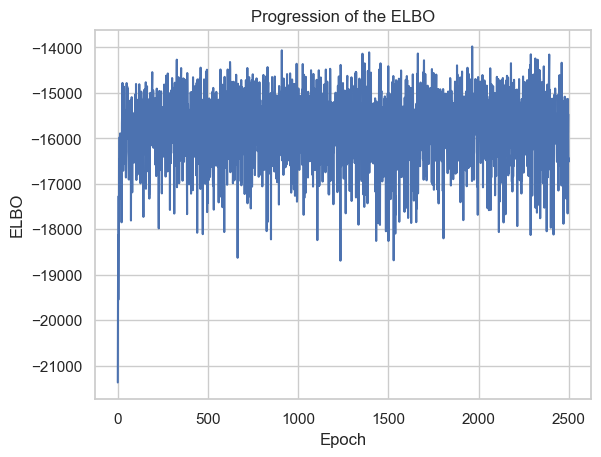

In [13]:
q.plot_elbo()

## Visualize the regression line 

In [14]:
b = q.trans_variational_params["beta_smooth"]["loc"]
b

Array([-2.6185398 , -2.626025  , -2.0041518 , -2.2619236 , -2.4003367 ,
       -2.1099794 , -1.6894892 , -1.4016992 , -1.1640717 , -0.6102212 ,
       -0.11400966,  0.45473555,  1.1069152 ,  1.5459895 ,  2.155803  ,
        2.8104978 ,  3.3854773 ,  3.6665118 ,  3.9382844 ], dtype=float32)

In [17]:
# for fixed and smooth terms
b_fixed = q.trans_variational_params["beta_fixed"]["loc"]
b_smooth = q.trans_variational_params["beta_smooth"]["loc"]
b = jnp.concatenate((b_fixed, b_smooth))
y = X.design_matrix @ b

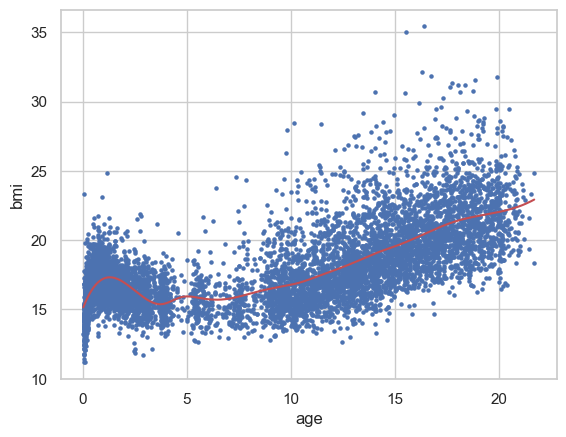

In [18]:
# plot the data
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
ax.plot(df["age"].to_numpy(), y, color = "r")
plt.show()

In [19]:
tau = q.trans_variational_params["tau"]["loc"]
s = q.trans_variational_params["tau"]["cov"]

In [20]:
tau, s

(Array([-0.33155257], dtype=float32), Array([[0.02827917]], dtype=float32))

In [21]:
m = jnp.exp(tau + s/2)

In [22]:
1 / (m ** 2)

Array([[1.8866937]], dtype=float32)